In [30]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_theme()

# Set the dataset directory (e.g., 'test_run')
DATASET_DIR = Path('../data/ml_datasets/test_run')  # Change this to your dataset directory

# Load the datasets
train_df = pd.read_parquet(DATASET_DIR / 'train.parquet')
val_df = pd.read_parquet(DATASET_DIR / 'val.parquet')
test_df = pd.read_parquet(DATASET_DIR / 'test.parquet')

print(f'Train shape: {train_df.shape}')
print(f'Val shape: {val_df.shape}')
print(f'Test shape: {test_df.shape}')

Train shape: (1539, 13)
Val shape: (504, 13)
Test shape: (507, 13)


In [32]:
def summarize_set(name, df):
    print(f'--- {name} ---')
    print(f'Shape: {df.shape}')
    print(f'Columns: {list(df.columns)}')
    print(f'Label distribution:')
    print(df['label'].value_counts(normalize=True).round(3))
    print()

summarize_set('Train', train_df)
summarize_set('Val', val_df)
summarize_set('Test', test_df)

--- Train ---
Shape: (1539, 13)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'above_ma50_daily_breadth', 'vix_market_volatility', 'vix_ma20_market_volatility', 'sentiment_ma5_market_sentiment', 'returns_1d_sector', 'ticker', 'label', 'Date']
Label distribution:
label
0.0    0.707
1.0    0.293
Name: proportion, dtype: float64

--- Val ---
Shape: (504, 13)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'above_ma50_daily_breadth', 'vix_market_volatility', 'vix_ma20_market_volatility', 'sentiment_ma5_market_sentiment', 'returns_1d_sector', 'ticker', 'label', 'Date']
Label distribution:
label
0    0.718
1    0.282
Name: proportion, dtype: float64

--- Test ---
Shape: (507, 13)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'above_ma50_daily_breadth', 'vix_market_volatility', 'vix_ma20_market_volatility', 'sentiment_ma5_market_sentiment', 'returns_1d_sector', 'ticker', 'label', 'Date']
Label distribution:
label
0    0.781
1    0.219
Name: proportion, dtype: float64



In [31]:
# Group by ticker and calculate the mean for sector columns
sector_cols = [col for col in train_df.columns if col.endswith('_sector')]
ticker_sector_means = train_df.groupby('ticker')[sector_cols].mean()

print(ticker_sector_means)

        returns_1d_sector
ticker                   
0                0.000719
1               -0.000109
2                0.000125


In [33]:
# Function to analyze NaN labels
def analyze_nan_labels(df, name):
    total_rows = len(df)
    nan_labels = df['label'].isna().sum()
    nan_percentage = (nan_labels / total_rows) * 100
    
    print(f"\n{name} Dataset Analysis:")
    print(f"Total rows: {total_rows}")
    print(f"Rows with NaN labels: {nan_labels}")
    print(f"Percentage of NaN labels: {nan_percentage:.2f}%")
    
    # Show sample of rows with NaN labels
    if nan_labels > 0:
        print("\nSample of rows with NaN labels:")
        print(df[df['label'].isna()].head())

# Analyze each dataset
analyze_nan_labels(train_df, "Training")
analyze_nan_labels(val_df, "Validation")
analyze_nan_labels(test_df, "Test")


Training Dataset Analysis:
Total rows: 1539
Rows with NaN labels: 18
Percentage of NaN labels: 1.17%

Sample of rows with NaN labels:
          Open        High         Low       Close      Volume  \
63  159.707834  160.637233  159.450772  160.528473  49501700.0   
64  160.607599  163.138719  160.083579  163.039841  68749800.0   
63  122.761785  122.922380  120.589014  121.628166  12134700.0   
64  122.487851  123.130230  121.722659  123.101891  13105200.0   
63  101.378275  101.396780  100.425101  101.322746  11578200.0   

    above_ma50_daily_breadth  vix_market_volatility  \
63                 28.112450              19.020000   
64                 28.514056              18.700001   
63                 28.112450              19.020000   
64                 28.514056              18.700001   
63                 28.112450              19.020000   

    vix_ma20_market_volatility  sentiment_ma5_market_sentiment  \
63                     21.9475                       -1.844726   
64   

In [29]:
print('Feature columns:', [col for col in train_df.columns if col not in ['ticker', 'label', 'Date']])
print('Total features:', len([col for col in train_df.columns if col not in ['ticker', 'label', 'Date']]))
print('Data types:')
print(train_df.dtypes.value_counts())

Feature columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'above_ma50_daily_breadth', 'vix_market_volatility', 'vix_ma20_market_volatility', 'sentiment_ma5_market_sentiment', 'returns_1d_sector']
Total features: 10
Data types:
float64           11
int64              1
datetime64[ns]     1
Name: count, dtype: int64


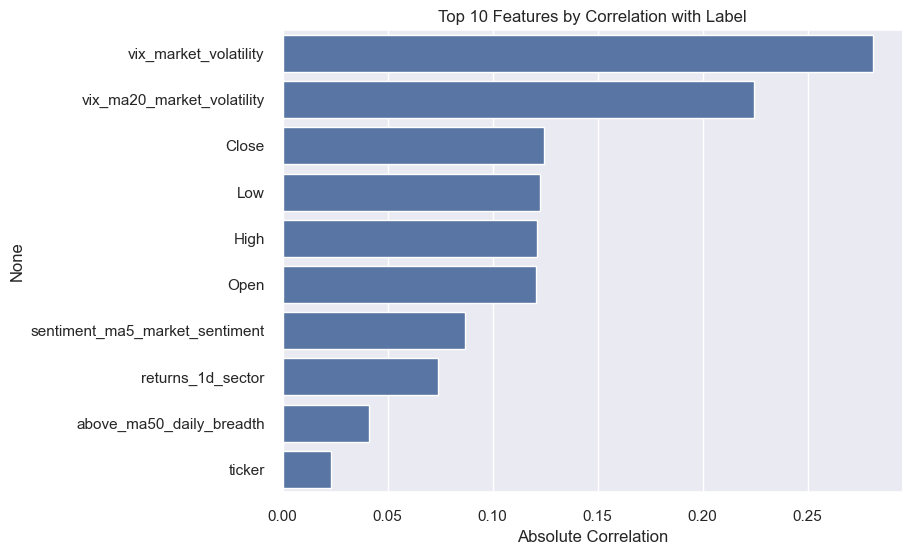

In [13]:
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
correlations = train_df[numeric_cols].corr()['label'].abs().sort_values(ascending=False)
top_features = correlations[1:11]  # Top 10 features (excluding label itself)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title('Top 10 Features by Correlation with Label')
plt.xlabel('Absolute Correlation')
plt.show()

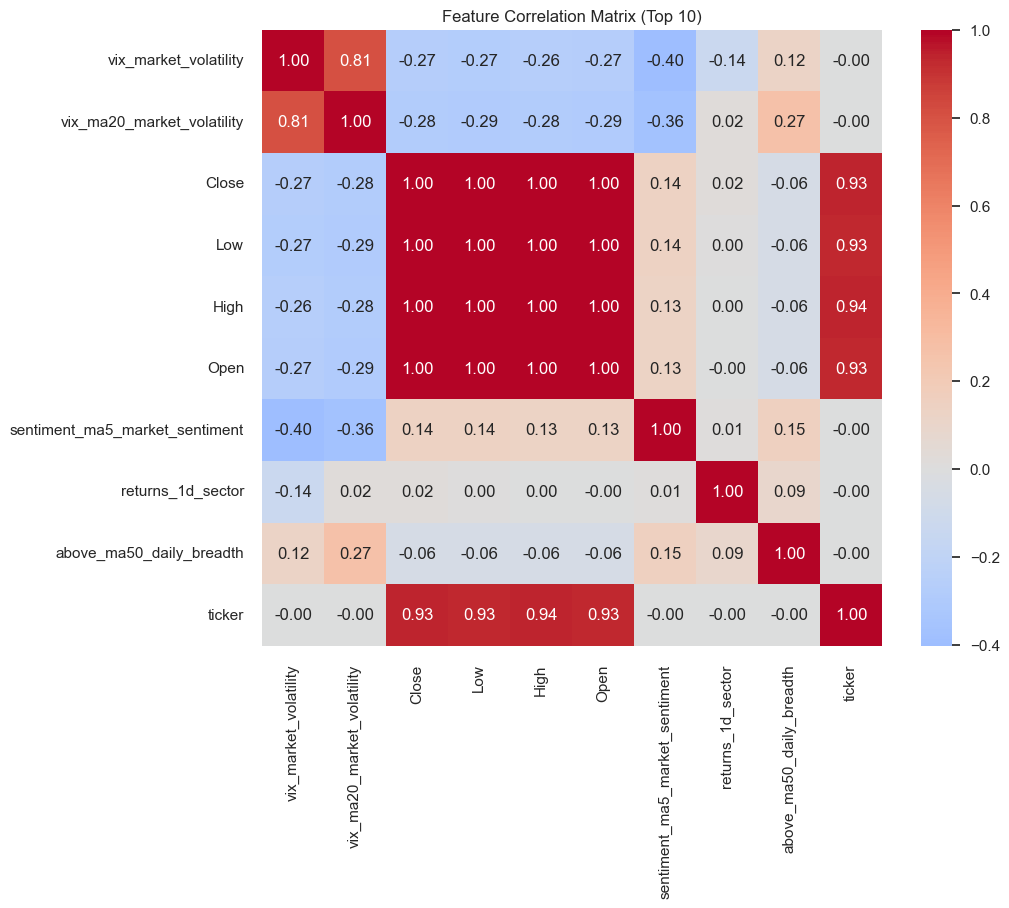

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[top_features.index].corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix (Top 10)')
plt.show()

In [1]:
import pandas as pd
import glob
from pathlib import Path
from collections import defaultdict

def analyze_dataframe_indices():
    # Get all parquet files recursively, excluding ml_datasets
    parquet_files = []
    for pattern in ['../data/ticker_features/*.parquet', '../data/market_features/**/*.parquet']:
        parquet_files.extend(glob.glob(pattern, recursive=True))
    
    # Dictionary to store unique index patterns
    index_patterns = defaultdict(list)
    
    print(f"Analyzing {len(parquet_files)} files...\n")
    
    for file_path in parquet_files:
        try:
            # Read the parquet file
            df = pd.read_parquet(file_path)
            
            # Get index information
            index_type = type(df.index).__name__
            index_dtype = str(df.index.dtype) if hasattr(df.index, 'dtype') else 'N/A'
            index_freq = df.index.freq if hasattr(df.index, 'freq') else 'N/A'
            
            # Create a pattern key
            pattern_key = f"Type: {index_type}, Dtype: {index_dtype}, Freq: {index_freq}"
            
            # Store file info under this pattern
            index_patterns[pattern_key].append({
                'file': Path(file_path).name,
                'range': f"{df.index.min()} to {df.index.max()}" if len(df.index) > 0 else "Empty",
                'length': len(df.index)
            })
            
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
    
    # Print results
    print("Index Pattern Analysis:")
    print("=" * 80)
    
    for pattern, files in index_patterns.items():
        print(f"\nPattern: {pattern}")
        print(f"Number of files with this pattern: {len(files)}")
        
        # Get date ranges
        if 'DatetimeIndex' in pattern:
            min_dates = [pd.to_datetime(f['range'].split(' to ')[0]) for f in files]
            max_dates = [pd.to_datetime(f['range'].split(' to ')[1]) for f in files]
            common_start = max(min_dates)
            common_end = min(max_dates)
            print(f"Common date range: {common_start} to {common_end}")
        
        # Get length statistics
        lengths = [f['length'] for f in files]
        print(f"Row count stats - Min: {min(lengths)}, Max: {max(lengths)}, Mean: {sum(lengths)/len(lengths):.1f}")
        
        # Show a few example files
        print("\nExample files:")
        for file_info in files[:3]:  # Show first 3 examples
            print(f"  - {file_info['file']}")
        if len(files) > 3:
            print(f"  ... and {len(files)-3} more")
        print("-" * 80)

# Run the analysis
analyze_dataframe_indices()

Analyzing 519 files...

Index Pattern Analysis:

Pattern: Type: DatetimeIndex, Dtype: datetime64[ns], Freq: None
Number of files with this pattern: 518
Common date range: 2024-07-08 00:00:00 to 2025-06-04 00:00:00
Row count stats - Min: 230, Max: 1826, Mean: 1248.0

Example files:
  - HON_features.parquet
  - HUBB_features.parquet
  - FDS_features.parquet
  ... and 515 more
--------------------------------------------------------------------------------

Pattern: Type: RangeIndex, Dtype: int64, Freq: N/A
Number of files with this pattern: 1
Row count stats - Min: 503, Max: 503, Mean: 503.0

Example files:
  - sector_mapping.parquet
--------------------------------------------------------------------------------


In [2]:
import pandas as pd
import glob
from pathlib import Path

def find_first_complete_date():
    # Get all parquet files recursively, excluding ml_datasets
    parquet_files = []
    for pattern in ['../data/ticker_features/*.parquet', '../data/market_features/**/*.parquet']:
        parquet_files.extend(glob.glob(pattern, recursive=True))
    
    # Dictionary to store first complete date for each file
    first_complete_dates = {}
    
    for file_path in parquet_files:
        try:
            # Read the parquet file
            df = pd.read_parquet(file_path)
            
            # Ensure the index is datetime
            if not isinstance(df.index, pd.DatetimeIndex):
                print(f"Warning: {file_path} does not have a datetime index")
                continue
            
            # For ticker_features files, exclude analyst_targets column
            if 'ticker_features' in file_path:
                df = df.drop(columns=['analyst_targets'], errors='ignore')
            
            # Find first row without any NaNs
            complete_rows = df.notna().all(axis=1)
            if complete_rows.any():
                first_complete_date = df.index[complete_rows].min()
                first_complete_dates[file_path] = first_complete_date
            else:
                print(f"Warning: {file_path} has no complete rows")
                
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
    
    if not first_complete_dates:
        return None
    
    # Find the latest first complete date across all files
    latest_first_date = max(first_complete_dates.values())
    
    # Print results
    print("\nFirst complete date for each file:")
    for file_path, date in sorted(first_complete_dates.items()):
        print(f"{Path(file_path).name}: {date}")
    
    print(f"\nLatest first complete date across all files: {latest_first_date}")
    return latest_first_date

# Run the function
first_complete_date = find_first_complete_date()


First complete date for each file:
daily_breadth.parquet: 2020-06-04 00:00:00
gdelt_raw.parquet: 2020-06-04 00:00:00
market_sentiment.parquet: 2020-06-23 00:00:00
market_volatility.parquet: 2020-07-30 00:00:00
Basic Materials.parquet: 2020-07-02 00:00:00
Communication Services.parquet: 2020-07-02 00:00:00
Consumer Cyclical.parquet: 2020-07-02 00:00:00
Consumer Defensive.parquet: 2020-07-02 00:00:00
Energy.parquet: 2020-07-02 00:00:00
Financial Services.parquet: 2020-07-02 00:00:00
Healthcare.parquet: 2020-07-02 00:00:00
Industrials.parquet: 2020-07-02 00:00:00
Real Estate.parquet: 2020-07-02 00:00:00
Technology.parquet: 2020-07-02 00:00:00
Utilities.parquet: 2020-07-02 00:00:00
AAPL_features.parquet: 2021-03-19 00:00:00
ABBV_features.parquet: 2021-03-19 00:00:00
ABNB_features.parquet: 2021-09-27 00:00:00
ABT_features.parquet: 2021-03-19 00:00:00
ACGL_features.parquet: 2021-03-19 00:00:00
ACN_features.parquet: 2021-03-19 00:00:00
ADBE_features.parquet: 2021-03-19 00:00:00
ADI_features.